# Assessment of Renewable Energy Potentials based on Land Availability

The analysis of land availability for renewable energy potentials is divided into three stages. In this script, we will focus on the second stage: **Scenarios**

-Goal: conduct analysis of power generation estimation, capacity, and capacity factor under assumptions.

-Steps: There are two approaches to find out final data and can analyze in different aspects (mean values data from stage 2, and time-serie data)

1. Import data (data from stage 2, time-series data)
2. Setup assumptions based on data (scenario3) from stage 2
3. Calculate the potentials capacity & annual generation based on data from stage 2
4. Calculate the potentials capacity & annual generation based on time-series data

In [1]:
# import necessary library
# Set-up to have matplotlib use its support for notebook inline plots
%matplotlib inline
import matplotlib.pyplot as plt # Convention for import of the pyplot interface
import os # operating system interfaces 
import datetime # time data sorting
import numpy as np # array and data sorting package
import pandas as pd # dataframe sorting package
import seaborn as sns # Use seaborn style defaults and set the default figure size
import geopandas # geospatial data processing package
import shapely.speedups # geospatial data speedup package
import rasterio # geospatial data (raster file) processing package
import contextily # the package for fetching basemaps
import glob # finds all the pathnames matching a specified pattern
import elevation # for elevation processing
import richdem as rd # package to deal with slope rate
import pyproj # self-defined coordination reference system
import xarray as xr # deal with time series data (grib and NetCDF files)
from matplotlib.patches import Patch # for legend editing
from matplotlib.colors import BoundaryNorm
from matplotlib import rcParams, cycler
from geopandas import datasets, GeoDataFrame, read_file # geospatial data processing package
from geopandas.tools import overlay # for overlay function
from shapely import wkt # provide dumpers and loaders inspired by Python’s pickle module
from shapely.geometry import Point # processing for data in point form
from rasterio.merge import merge
from rasterio.plot import show # plot the raster data
from rasterio.plot import show_hist
from rasterstats import zonal_stats
from pyproj import CRS # self-defined coordination reference system
from pyproj import Geod # performs forward and inverse geodetic, or Great Circle, computations
from osgeo import gdal, gdal_array

In [2]:
# spped up the calculation of mapping in shapely library
shapely.speedups.enable()

## 1. Import data (data from stage 2, time-series data)

a. Import the **land area** which is **scenario 3** from the **result of stage 2**

b. Import the **time-series** for calculation

In [4]:
# Import final available land (from stgae 2)
land_gdf = pd.read_csv('Vietnam/02_output_stage2/02_vn_scenario3_al_ts_sl.csv')

# Import result data of wind resources from stge 2
sc3_wind_gdf = pd.read_csv('Vietnam/02_output_stage2/02_vn_scenario3_wind.csv')

# Import result data of solar resources from stge 2
sc3_solar_gdf = pd.read_csv('Vietnam/02_output_stage2/02_vn_scenario3_solar.csv')

In [7]:
# import data (ERA5, Latitude x Longtitude: 0.25° x 0.25°)
ds = xr.open_dataset('Vietnam/00_data_time_series/hourly_data_2020_era5.nc')
# convert time series data (ds) to dataframe
df = ds.to_dataframe()

# drop all index
df.reset_index(drop=False, inplace=True)

# reset time column into date time and select it as new index
df["time"] = pd.to_datetime(df["time"])
df.set_index('time')

# add year, month and day name
df['year'] = pd.DatetimeIndex(df['time']).year
df['month'] = pd.DatetimeIndex(df['time']).month
df['day'] = pd.DatetimeIndex(df['time']).day
df.head()

,latitude,longitude,time,u100,v100,fdir,year,month,day
0,24.0,101.0,2020-01-01 00:00:00,0.498847,0.980772,0.000,2020,1,1
1,24.0,101.0,2020-01-01 01:00:00,0.199315,0.907117,24523.625,2020,1,1
2,24.0,101.0,2020-01-01 02:00:00,0.110454,0.916045,97986.875,2020,1,1
3,24.0,101.0,2020-01-01 03:00:00,0.580720,0.776548,263574.875,2020,1,1
4,24.0,101.0,2020-01-01 04:00:00,0.564745,0.695081,266317.625,2020,1,1


In [8]:
# wind time series data
# wind speed = (u**2 + v**2)**(1/2)
df['wind_speed_at_height_100m[m/s]'] = ((df['u100'])**2 + (df['v100'])**2)**(1/2)

# solar time series data
# from j/m2 to kWh/m2
# 1kwh = 3.6 x10**6 j
df['Total sky direct solar radiation at surface[Wh/m2]'] = df['fdir']/(3.6*(10**3))

#rename the titles
# create a dictionary and renew the titles

dict = {'u100': 'u-component_of_wind_speed_at_height_100m[m/s]',
        'v100': 'v-component_of_wind_speed_at_height_100m[m/s]',
        'fdir': 'Total sky direct solar radiation at surface[J/m2]',
       }

# call rename () method
df.rename(columns=dict,
          inplace=True)

df = df[['latitude', 'longitude', 'time', 'year', 'month', 'day',
         'u-component_of_wind_speed_at_height_100m[m/s]', 
         'v-component_of_wind_speed_at_height_100m[m/s]', 
         'wind_speed_at_height_100m[m/s]',
         'Total sky direct solar radiation at surface[J/m2]', 
         'Total sky direct solar radiation at surface[Wh/m2]']]
df.head()

,latitude,longitude,time,year,month,day,u-component_of_wind_speed_at_height_100m[m/s],v-component_of_wind_speed_at_height_100m[m/s],wind_speed_at_height_100m[m/s],Total sky direct solar radiation at surface[J/m2],Total sky direct solar radiation at surface[Wh/m2]
0,24.0,101.0,2020-01-01 00:00:00,2020,1,1,0.498847,0.980772,1.100346,0.000,0.000000
1,24.0,101.0,2020-01-01 01:00:00,2020,1,1,0.199315,0.907117,0.928756,24523.625,6.812118
2,24.0,101.0,2020-01-01 02:00:00,2020,1,1,0.110454,0.916045,0.922680,97986.875,27.218576
3,24.0,101.0,2020-01-01 03:00:00,2020,1,1,0.580720,0.776548,0.969671,263574.875,73.215240
4,24.0,101.0,2020-01-01 04:00:00,2020,1,1,0.564745,0.695081,0.895586,266317.625,73.977119


## 2. Setup assumptions based on data (scenario3) from stage 2

### a. Divide the land area into different regions in Vietnam
The regions area defined based on https://en.wikipedia.org/wiki/List_of_regions_of_Vietnam

In [11]:
# separate into regions: Northeast, Northwest, Red River Delta, North Central Coast, South Central Coast, Central Highlands, Southeast, Mekong River Delta 
# Northwest
nw_list = ['Dien Bien','Hoa Binh', 'Lai Chau', 'Lao Cai', 'Son La', 'Yen Bai']
nw_land_df = land_gdf[land_gdf['ADM1_EN'].str.contains('|'.join(nw_list))]
# Northeast
ne_list = ['Bac Giang','Bac Kann', 'Cao Bangu', 'Ha Giang', 'Lang Son', 'Phu Tho', 'Quang Ninh', 'Thai Nguyen', 'Tuyen Quang']
ne_land_df = land_gdf[land_gdf['ADM1_EN'].str.contains('|'.join(ne_list))]
# Red River Delta
rrd_list = ['Bac Ninh', 'Ha Nam', 'Ha Noi', 'Hai Duong', 'Hai Phong', 'Hung Yen', 'Nam Dinh', 'Ninh Binh', 'Thai Binh', 'Vinh Phuc']
rrd_land_df = land_gdf[land_gdf['ADM1_EN'].str.contains('|'.join(nw_land_df))]
# North Central Coast
ncc_list = ['Ha Tinh', 'Nghe An', 'Quang Binh', 'Quang Tri', 'Thanh Hoa', 'Thua Thien Hue']
ncc_land_df = land_gdf[land_gdf['ADM1_EN'].str.contains('|'.join(ncc_list))]
# South Central Coast
scc_list = ['Binh Dinh', 'Binh Thuan', 'Da Nang', 'Khanh Hoa', 'Ninh Thuan', 'Phu Yen', 'Quang Nam', 'Quang Ngai']
scc_land_df = land_gdf[land_gdf['ADM1_EN'].str.contains('|'.join(scc_list))]
# Central Highlands
ch_list = ['Dak Lak', 'Dak Nong', 'Gia Lai', 'Kon Tum', 'Lam Dong']
ch_land_df = land_gdf[land_gdf['ADM1_EN'].str.contains('|'.join(ch_list))]
# Southeast
se_list = ['Ba Ria Vung Tau', 'Binh Duong', 'Binh Phuoc', 'Dong Nai', 'Saigon', 'Tay Ninh']
se_land_df = land_gdf[land_gdf['ADM1_EN'].str.contains('|'.join(se_list))]
# Mekong River Delta
mrd_list = ['An Giang', 'Ben Tre', 'Bac Lieu', 'Ca Mau', 'Can Tho City', 'Dong Thap', 'Hau Giang',
             'Kien Giang', 'Long An', 'Soc Trang', 'Tien Giang', 'Tra Vinh', 'Vinh Long']
mrd_land_df = land_gdf[land_gdf['ADM1_EN'].str.contains('|'.join(mrd_list))]

## 3. Calculate the potentials capacity & annual generation based on data from stage 2

### a. Calculate the total land area

In [14]:
name = 'Vietnam'
land_sum = land_gdf['area_km2'].sum(axis = 0, skipna = True)
# Total areas in square kilometers
print('Total area of scenario 3 in', name, ':', land_sum,'km^2')

Total area of scenario 3 in Vietnam : 1611.7824709170907 km^2


### b. Calculate the potential capacity based on HC/LC profile assumptions

In [34]:
# wind
# HC/LC profile
# capactiy of one wind turbine according to High Capacity (HC) Profile (5 MW)
wt_hc_c = 5
# capactiy of one wind turbine according to Low Capacity (LC) Profile (2 MW)
wt_lc_c = 2
# distance between wind turbine: L*W = (5*rotor diameter)*(5*rotor diameter) (km2)
wt_d = 5*0.1*5*0.1

# potential capacity of HC/LC profile (GW) = (land area * capacity of one wind turbine) / (distance between wind turbines * 1000)
wt_pc_lc = land_sum*wt_lc_c/wt_d/1000
wt_pc_hc = land_sum*wt_hc_c/wt_d/1000
print('Onshore wind potential capacity of scenario 3 in', name, ':', '\n (1) LC Profile:', wt_pc_lc,'GW', '\n (2) HC Profile:', wt_pc_hc,'GW')

Onshore wind potential capacity of scenario 3 in Vietnam : 
 (1) LC Profile: 12.894259767336726 GW 
 (2) HC Profile: 32.235649418341815 GW


In [32]:
# solar
# HC/LC profile
# capactiy of one PV panel according to High Capacity (HC) Profile (450 Wp) / Power Density (150 MW/km2)
pv_hc_c = 450
pv_hc_pd = 150
# capactiy of one PV panel according to Low Capacity (LC) Profile (300 Wp)/ Power Density (60 MW/km2)
pv_lc_c = 300
pv_lc_pd = 60
# performance ratio of one PV panel (%)
pv_pr = 0.8

# potential capacity of HC/LC profile (GW) = (land area * power density of one PV panel) / 1000
pv_pc_lc = land_sum*pv_lc_pd/1000
pv_pc_hc = land_sum*pv_hc_pd/1000
print('Utility-Scale PV potential capacity of scenario 3 in', name, ':', '\n (1) LC Profile:', pv_pc_lc,'GW', '\n (2) HC Profile:', pv_pc_hc,'GW')

Utility-Scale PV potential capacity of scenario 3 in Vietnam : 
 (1) LC Profile: 96.70694825502545 GW 
 (2) HC Profile: 241.7673706375636 GW


### c. Calculate average value of solar and wind parameters for annual generation assumptions
- Wind (Onshore): capacity factor (according to wind class IEC1-IEC3)
- Solar (Utiliy-scale PV): PVOUT (power density, GWh/GWp)

In [30]:
wt_cf1_sum = sc3_wind_gdf['capacity_factor_iec1'].mean(axis = 0, skipna = True)
wt_cf2_sum = sc3_wind_gdf['capacity_factor_iec2'].mean(axis = 0, skipna = True)
wt_cf3_sum = sc3_wind_gdf['capacity_factor_iec3'].mean(axis = 0, skipna = True)
pv_out_sum = sc3_solar_gdf['pvout_kWh/kWp'].mean(axis = 0, skipna = True)

### d. Calculate the estimated annual generation

In [36]:
# wind
# HC/LC profile

# oneshore windfarm estimated annual generation of HC/LC profile (TWh) = (potential capacity * capactiy factor * 8760 hours) / 1000
wt_ag_cf1_lc = wt_pc_lc*wt_cf1_sum*8760/1000
wt_ag_cf2_lc = wt_pc_lc*wt_cf2_sum*8760/1000
wt_ag_cf3_lc = wt_pc_lc*wt_cf3_sum*8760/1000
wt_ag_cf1_hc = wt_pc_hc*wt_cf1_sum*8760/1000
wt_ag_cf2_hc = wt_pc_hc*wt_cf2_sum*8760/1000
wt_ag_cf3_hc = wt_pc_hc*wt_cf3_sum*8760/1000
print('Onshore windfarm estimated annual generation of scenario 3 in', name, ':', 
      '\n (1) LC Profile in wind class IEC1:', wt_ag_cf1_lc,'TWh', 
      '\n (2) LC Profile in wind class IEC2:', wt_ag_cf2_lc,'TWh', 
      '\n (3) LC Profile in wind class IEC3:', wt_ag_cf3_lc,'TWh', 
      '\n (4) HC Profile in wind class IEC1:', wt_ag_cf1_hc,'TWh', 
      '\n (5) HC Profile in wind class IEC2:', wt_ag_cf2_hc,'TWh',
      '\n (6) HC Profile in wind class IEC3:', wt_ag_cf3_hc,'TWh')

Onshore windfarm estimated annual generation of scenario 3 in Vietnam : 
 (1) LC Profile in wind class IEC1: 18.556895401360375 TWh 
 (2) LC Profile in wind class IEC2: 22.913443443081245 TWh 
 (3) LC Profile in wind class IEC3: 26.249440358430437 TWh 
 (4) HC Profile in wind class IEC1: 46.39223850340094 TWh 
 (5) HC Profile in wind class IEC2: 57.28360860770312 TWh 
 (6) HC Profile in wind class IEC3: 65.6236008960761 TWh


In [40]:
# solar
# HC/LC profile

# Utility-Scale PV estimated annual generation of HC/LC profile (TWh) = (potential capacity * PVOUT) / 1000
pv_ag_lc = pv_pc_lc*pv_out_sum/1000
pv_ag_hc = pv_pc_hc*pv_out_sum/1000
print('Utility-Scale PV potential capacity of scenario 3 in', name, ':', 
      '\n (1) LC Profile:', pv_ag_lc,'TWh', 
      '\n (2) HC Profile:', pv_ag_hc,'TWh')

Utility-Scale PV potential capacity of scenario 3 in Vietnam : 
 (1) LC Profile: 125.94793806548785 TWh 
 (2) HC Profile: 314.86984516371956 TWh


## 5. Calculate the potentials capacity & annual generation based on time-series data

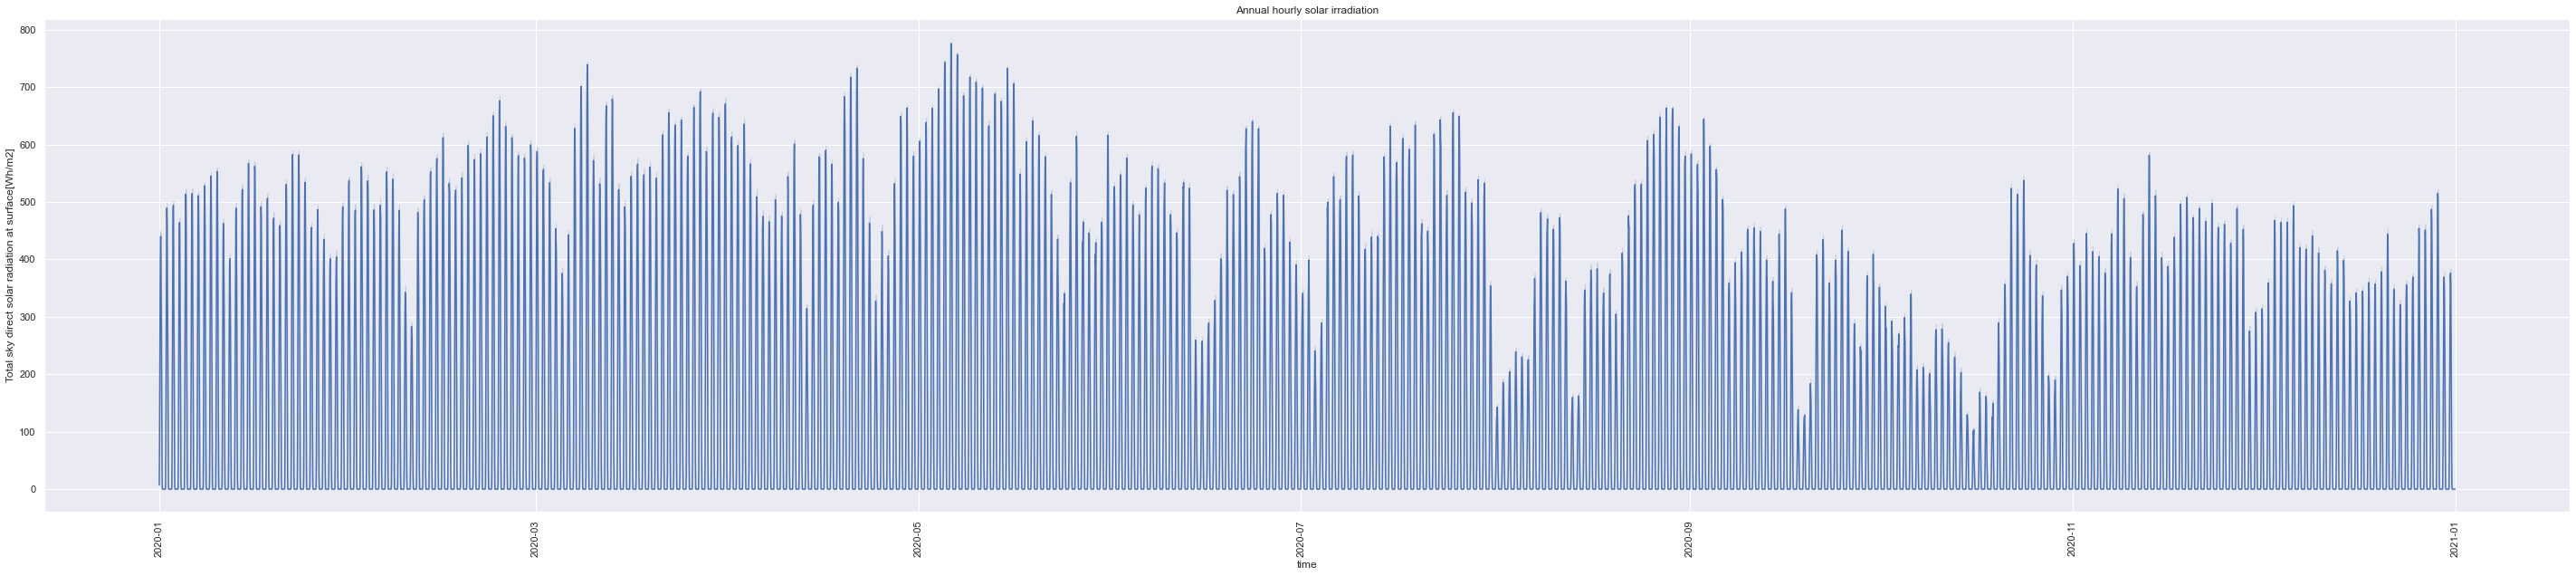

In [11]:
sns.set(rc={'figure.figsize':(50,10)})
sns.lineplot(x="time", y="Total sky direct solar radiation at surface[Wh/m2]", data=df)
plt.xticks(rotation='vertical')
plt.title('Annual hourly solar irradiation')
plt.savefig(r'Vietnam/03_output_stage3/03_annual_hourly_solar_irradiation.tiff', dpi=300)
plt.show()

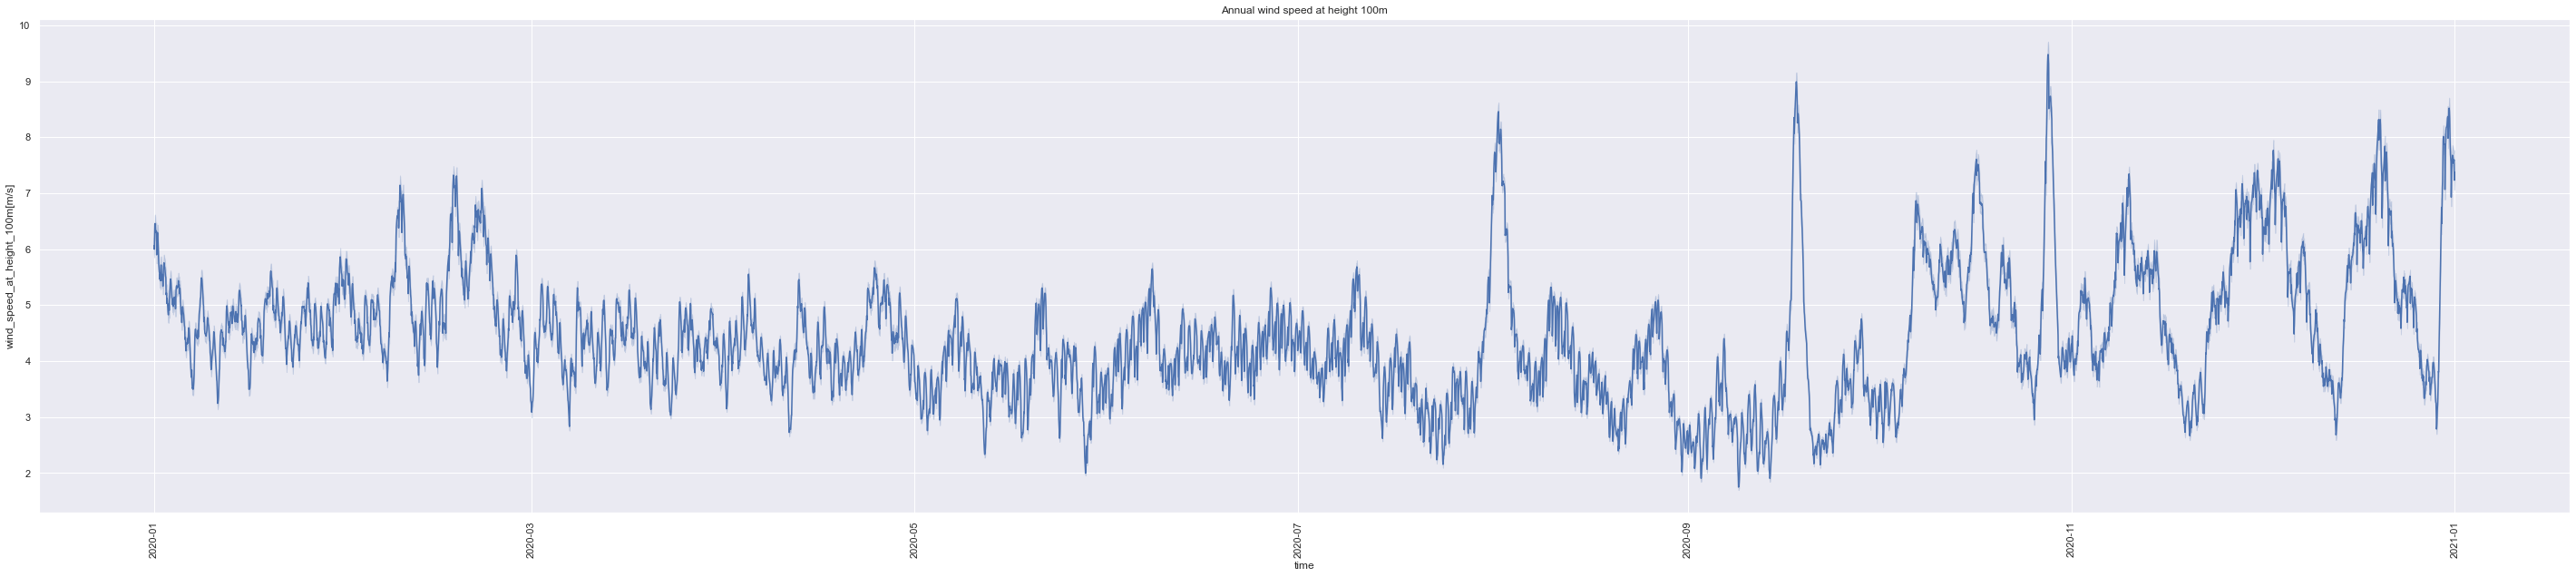

In [12]:
sns.set(rc={'figure.figsize':(50,10)})
sns.lineplot(x="time", y="wind_speed_at_height_100m[m/s]", data=df)
plt.xticks(rotation='vertical')
plt.title('Annual wind speed at height 100m')
plt.savefig(r'Vietnam/03_output_stage3/03_annual_hourly_wind_speed.tiff', dpi=300)
plt.show()